© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# 🌀 Generalized Linear Models

So far we have only worked with simple linear classification/regression models, which minimize squared loss:

$$
\min_{w,b} \ \dfrac{1}{2N} \sum_{i=1}^N \left(h(x_i) - y_i\right)^2 + \lambda \mathcal{P}(w),
$$

where:
- $h(x) = \langle x, w \rangle + b$ is the linear model's decision function,
- $\mathcal{P}(w)$ is the regularization term,
- and $\lambda$ is the regularization hyperparameter.


**GLMs** extend linear models by introducing two key ideas:

- **Non-linear activation function:**  
  The decision function becomes  
  $$
  h(x) = \alpha\left(\langle x, w \rangle + b \right),
  $$  
  where $\alpha(\cdot)$ is a (typically non-linear) activation function.

- **Flexible loss function:**  
  Instead of MSE, GLMs can use a more appropriate loss function $\mathcal{L}$:
  $$
  \min_{w,b} \ \dfrac{1}{N} \sum_{i=1}^N \mathcal{L}(h(x_i), y_i) + \lambda \mathcal{P}(w)
  $$


# 📚 Logistic Regression

**Logistic Regression** is a GLM used for **binary classification**, where the activation function is the **sigmoid**:

$$
\alpha(t) = \frac{1}{1 + e^{-t}}
$$

Let’s begin by plotting the sigmoid function.


In [1]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"{repo_root} added to sys.path.")
else:
    print("Repo root already in sys.path.")

/Users/maria.selezniova/lib/Teaching/AppliedML/AppliedML added to sys.path.


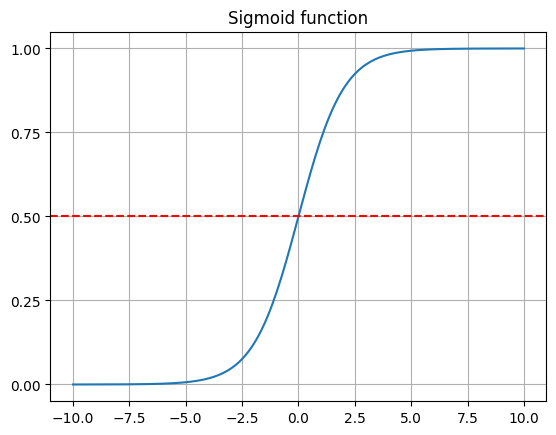

In [2]:
def sigmoid(x):
    return 1./(1.+np.exp(-x))

x = np.linspace(-10,10,200)

plt.plot(x, sigmoid(x))
plt.axhline(y=0.5, color='r', linestyle='--')
plt.yticks([0,0.25,0.5,0.75,1])

plt.title('Sigmoid function')
plt.grid()

## 🎯 Output Range and Label Choice

One can see that the output of the logistic regression model lies between 0 and 1:

$$
h(x) \in [0, 1]
$$

Therefore, a natural choice of class labels for binary classification is:

$$
Y \in \{0, 1\}
$$

(instead of using labels $+1$ and $-1$ as we did previously).

This choice can be interpreted probabilistically: $h(x)$ is a probability of the **presence or absence of a single property**, such as:
- "Does the patient have a disease?"
- "Will the company go bankrupt?"


## 📉 Loss Function: Cross-Entropy

Logistic regression uses the **cross-entropy loss**, which measures the dissimilarity between the predicted probability $y'$ and the true label $y$:

$$
\mathcal{L}(y, y') = - y \log(y') - (1 - y) \log(1 - y')
$$

Note that this loss only makes sense when $y \in \{0, 1\}$ and $y' \in (0, 1)$ — a key reason for using $\{0, 1\}$ labels.

The loss simplifies to:

$$
\mathcal{L}(y, y') = \begin{cases}
- \log(y') & \text{if } y = 1 \\
- \log(1 - y') & \text{if } y = 0
\end{cases}
$$


## 🧮 Logistic Regression Objective

Putting everything together, the full optimization problem of logistic regression is:

$$
\min_{w, b} \ \dfrac{1}{N} \sum_{i=1}^N \left[ y_i \log\left(1 + e^{- (\langle x_i, w \rangle + b)}\right) + (1 - y_i) \log\left(1 + e^{\langle x_i, w \rangle + b} \right) \right] + \lambda \mathcal{P}(w, b)
$$

We’ll now implement and train this model using our `courselib` package.


# 🧪 Logistic Regression on Breast Cancer Wisconsin (Diagnostic) Dataset

In this section, we'll apply **logistic regression** to the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

🎯 **Goal:** Predict whether a tumor is **malignant** or **benign** based on characteristics of cell nuclei observed in a fine needle aspirate (FNA) of a breast mass.

We will load the dataset using the csv loading function from `courselib.utils.loaders`.

In [3]:
from courselib.utils.loaders import load_or_download_csv

file_name = 'breast_cancer.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
column_names = ['id','Clump Thickness','Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion',
               'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

df = load_or_download_csv(file_name,url,column_names)

df

Loading from local `breast_cancer.csv`...


,id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


🛠️ The original labels are `2` for benign and `4` for malignant. We'll preprocess the labels to be:
- `0` for **benign**
- `1` for **malignant**

And remove rows with missing values.

In [4]:
df['Class'] = df['Class'].replace([2,4],[0,1])
df = df[df['Bare Nuclei']!='?'].astype(float) #remove lines with missing values

The train-test split can be done using a function from `courselib.utils.splits`.

In [5]:
from courselib.utils.splits import train_test_split

training_data_fraction = .8

X, Y, train_X, train_Y, test_X, test_Y =  train_test_split(df, training_data_fraction, return_numpy=True)


print('Training data split as follows:')
print(f'  Training data samples: {len(train_X)}')
print(f'      Test data samples: {len(test_X)}')

Training data split as follows:
  Training data samples: 546
      Test data samples: 137


## 🧮 Logistic Regression Implementation

Recall the logistic regression objective (for now **without regularization**):

$$
\min_{w, b} \ \dfrac{1}{2N} \sum_{i=1}^N \left[ 
    - y_i \log\left( \alpha(\langle x_i, w \rangle + b) \right)
    - (1 - y_i) \log\left( 1 - \alpha(\langle x_i, w \rangle + b) \right),
\right]
$$

where, $\alpha(t)$ is the sigmoid function.


> ### 💡 Gradients Calculation
>
>Let’s denote $\hat{y}_i = \alpha(\langle x_i, w \rangle + b)$, and define the average empirical risk:
>
>- Gradient w.r.t. **weights** $w$:
>  $$
>  \nabla_w \hat{\mathcal{L}}(w, b, X, Y) = \frac{1}{N} \sum_{i=1}^N \left( h(x_i) - y_i \right) x_i 
>  = \frac{1}{N} X^T \left( \alpha(Xw + b) - Y \right)
>  $$
>
>- Gradient w.r.t. **bias** $b$:
>  $$
>  \nabla_b \hat{\mathcal{L}}(w, b, X, Y) = \frac{1}{N} \sum_{i=1}^N \left( h(x_i) - y_i \right) 
>  = \frac{1}{N} \mathbf{1}_N^T \left( \alpha(Xw + b) - Y \right)
>  $$
>

We now implement a logistic regression class as a subclass of `TrainableModel` class from `courselib.models.base`.

In [6]:
from courselib.models.base import TrainableModel

class LogisticRegression(TrainableModel):
    """
    Binary logistic regression model.

    Parameters:
        - w: Initial weights (array-like)
        - b: Initial bias (scalar)
        - optimizer: Optimizer object (e.g., GDOptimizer)
    """
    
    def __init__(self, w, b, optimizer):
        super().__init__(optimizer)
        self.w = np.array(w, dtype=float)
        self.b = np.array(b, dtype=float)

    def loss_grad(self, X, y):
        residual = self.decision_function(X) - y
        grad_w = X.T @ residual / len(X)
        grad_b = np.mean(residual)
        return {"w": grad_w, "b": grad_b}
    
    def decision_function(self, X):
        return sigmoid(X @ self.w + self.b)
    
    def _get_params(self):
        """
        Return model parameters as a dict for the optimizer.
        """
        return {"w": self.w, "b": self.b}

    def __call__(self, X):
        return np.where(self.decision_function(X) >= 0.5, 1, 0)


### ⚙️ Note on Parameter Handling in `courselib`

In our `courselib` design, each model must implement a `_get_params()` method that returns its parameters as a **dictionary**, for example:

```python
{"w": self.w, "b": self.b}
```
Except for this, any model that subclasses `TrainableModel` must implement `loss_grad()` to return gradients as a dictionary to ensure compatibility with the optimizer.

This design is essential because the **optimizer logic** is written to be **generic** — it expects parameters and gradients in dictionary form, rather than accessing model-specific attributes directly. 

### 🧪 Instantiating and Training Logistic Regression

In this example, we train a logistic regression model using gradient descent.  
The `fit` method of `TrainableModel` implements a **generic mini-batch iterative training procedure**, while the `Optimizer` object specifies **how each update is works**.

Here’s what each part of the code does:

- `GDOptimizer`: Our optimizer, configured with a learning rate of `0.01`
- We import two evaluation metrics from `courselib.utils.metrics`:
  - `binary_accuracy`: Measures classification accuracy given class labels. Here we specify `{0, 1}` as the label set.
  - `mean_squared_error`: Measures squared error between predictions and targets.
- These metrics are passed to the training loop using `metrics_dict`, which is used by the `compute_metrics` method of `TrainableModel`.
- The model is trained for 20,000 epochs using **full-batch gradient descent** (`batch_size = len(train_X)`), meaning it uses the entire dataset for each parameter update.


In [7]:
from courselib.utils.metrics import binary_accuracy, mean_squared_error
from courselib.optimizers import GDOptimizer

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy = lambda y_true,y_pred: binary_accuracy(y_true,y_pred,class_labels=[0,1])
metrics_dict = {'accuracy': accuracy,
                'MSE': mean_squared_error}


model = LogisticRegression(w, b, optimizer)
metrics_history = model.fit(train_X,train_Y,num_epochs=20000, batch_size=len(train_X), compute_metrics=True, metrics_dict=metrics_dict)

### 📈 Learning Curve

The final train accuracy: 97.25274725274726%
Test accuracy: 96.35036496350365%


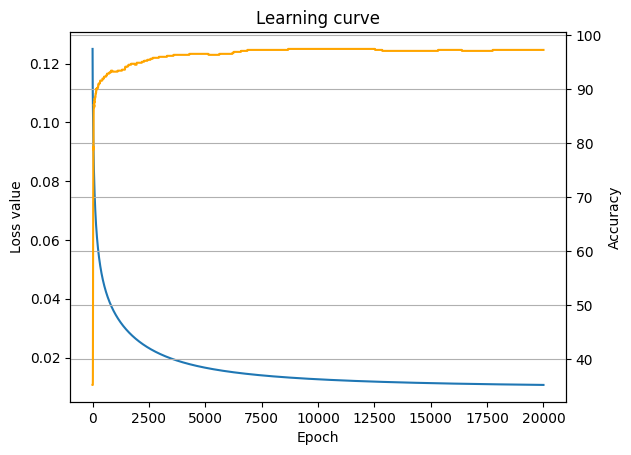

In [8]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {metrics_history['accuracy'][-1]}%')
print(f'Test accuracy: {accuracy(model.decision_function(test_X), test_Y)}%')

## 🔁 Comparison: Linear Binary Classification

For comparison, let us solve the same classification problem using the **linear binary classification model** introduced in earlier lectures.

We can now simply import the model from the `courselib.models.linear_models` module. In this version, the model has been extended to allow **custom class labels**, which we set to `{0, 1}` to match the logistic regression setup.


In [9]:
from courselib.models.linear_models import LinearBinaryClassification

w = [0]*X.shape[1]
b = 0

model = LinearBinaryClassification(w, b,optimizer,class_labels=[0,1])
metrics_history = model.fit(train_X,train_Y,num_epochs=20000, batch_size=len(train_X), compute_metrics=True, metrics_dict=metrics_dict)

The final train accuracy: 96.52014652014653%
Test accuracy: 96.35036496350365%


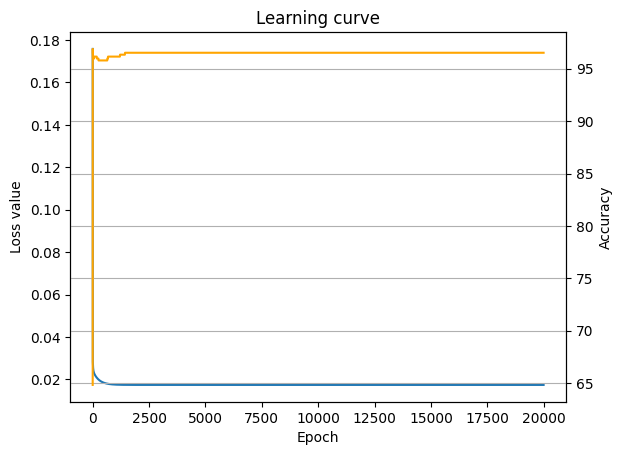

In [10]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {metrics_history['accuracy'][-1]}%')
print(f'Test accuracy: {accuracy(model.decision_function(test_X), test_Y)}%')

## Cross-validation

In [11]:
from courselib.utils.splits import k_fold_split

X_cv, Y_cv = k_fold_split(X,Y,k=5)

acc_logreg = []
acc_linreg = []

for i in range(len(X_cv)):
    x_train = np.concatenate(X_cv[:i] + X_cv[i+1:])
    y_train = np.concatenate(Y_cv[:i] + Y_cv[i+1:])
    x_test = X_cv[i]
    y_test = Y_cv[i]
    
    w = [0]*X.shape[1]
    b = 0
    
    model = LogisticRegression(w, b, optimizer)
    model.fit(x_train,y_train, num_epochs = 20000, batch_size=len(x_train))

    acc_logreg.append(accuracy(model.decision_function(x_test),y_test))
    
    model = LinearBinaryClassification(w, b, optimizer, class_labels=[0,1])
    model.fit(x_train,y_train, num_epochs = 20000, batch_size=len(x_train))

    acc_linreg.append(accuracy(model.decision_function(x_test),y_test))
    
print(f'CV accuracy Logistic Regression: {np.mean(acc_logreg)}')
print(f'CV accuracy Linear Regression: {np.mean(acc_linreg)}')

CV accuracy Logistic Regression: 96.34177758694719
CV accuracy Linear Regression: 96.0465865178188


## 🎯 Motivation: Maximum Likelihood Estimation (MLE)

**Maximum Likelihood Estimation (MLE)** is a general method for estimating parameters of a probability distribution from data. Assume we have a dataset $X = (x_i)_{i=1}^N$, $Y = (y_i)_{i=1}^N$, and the conditional distribution $P(y|x; w)$ is parameterized by $w$.

The **likelihood** function gives the probability of observing the given labels under model parameters $w$:

$$
\mathcal{L}(w \mid X,Y) = \prod_{i=1}^N P(y = y_i \mid x=x_i; w)
$$

MLE chooses the parameters that **maximize the likelihood** of the observed data.

Since products are harder to optimize, we typically maximize the **log-likelihood** instead:

$$
\log \mathcal{L}(w \mid X,Y) = \sum_{i=1}^N \log P(y = y_i \mid x=x_i; w)
$$

Because the logarithm is a **monotonic function**, maximizing the log-likelihood is equivalent to maximizing the original likelihood:

$$
\underset{w}{\operatorname{argmax}} \ \mathcal{L}(w \mid X, Y)
\ \Leftrightarrow \
\underset{w}{\operatorname{argmax}} \ \log \mathcal{L}(w \mid X, Y)
$$


## 📉 Linear Regression via MLE

- Assumes that $y \sim \mathcal{N}(h(x), \sigma^2)$, where $h(X) = \langle x, w\rangle$:

$$
P(y = y_i \mid x=x_i;  w) \propto \exp\left( - \frac{(y_i - \langle x_i, w \rangle)^2}{2\sigma^2} \right)
$$

- So, maximizing the log-likelihood is equivalent to **minimizing the MSE**:

$$
\underset{w}{\operatorname{argmax}} \ \log \mathcal{L}(w \mid X, Y)
\ \Leftrightarrow \
\underset{w}{\operatorname{argmin}} \ \sum_{i=1}^N (y_i - \langle x_i, w \rangle)^2
\ \Leftrightarrow \
\underset{w}{\operatorname{argmin}} \ \|Xw - Y\|_2^2
$$

- Linear regression outputs **real-valued predictions**, which are point estimates of $y$.



## 🔐 Logistic Regression via MLE

- Assumes that $y \sim \text{Bernoulli}(h(x))$, where $h(x) = \alpha(\langle w, x \rangle + b)$ and $\alpha$ is the sigmoid function.

$$
P(y = y_i \mid x=x_i;  w) = h(x_i)^{y_i} (1 - h(x_i))^{1 - y_i}
$$

Taking log:

$$
\log P(y = y_i \mid x=x_i; w) = y_i \log h(x_i) + (1 - y_i) \log(1 - h(x_i)) = - \mathcal{L}_{\text{CE}}(y_i, h(x_i))
$$

- Therefore, maximizing the log-likelihood is equivalent to **minimizing cross-entropy loss**:

$$
\underset{w}{\operatorname{argmax}} \log \mathcal{L}(w \mid X, Y)
\ \Leftrightarrow \
\underset{w}{\operatorname{argmin}} \sum_{i=1}^N - y_i \log h(x_i) - (1 - y_i) \log (1 - h(x_i))
$$

- Logistic regression outputs the **probability** that $y = 1$ for a given input:

$$
h(x) = P(y = 1 \mid x, w) \in [0, 1]
$$


## 🧠 How to Choose the Activation Function?

In GLMs, we assume the model predicts the **expected value** of $y$ given $x$:

$$
h(x) = \alpha(\langle w, x \rangle + b) = \mathbb{E}[y \mid x, w]
$$

### ✅ Activation function requirements:

- The **range** of $\alpha: \mathbb{R} \rightarrow \mathbb{R}$ must match the range of possible outcomes:
  - $\alpha(x) \in [0, 1]$ for **Bernoulli**
  - $\alpha(x) \in \mathbb{R}$ for **Gaussian**

- $\alpha$ should be:
  - **Differentiable** (for gradient-based optimization)
  - A good match to the **structure of the data**
  - Many theoretical results require $\alpha$ to be **invertible** 


### ⚠️ Gradient Stability

Consider the gradient of a GLM loss:

$$
\nabla_w \mathcal{L}(y, h(x)) = \frac{\partial \mathcal{L}}{\partial h(x)} \cdot \alpha'(\langle x, w \rangle) \cdot x
$$

The gradient depends on both the loss and the activation:

- With **cross-entropy** and **linear activation** $\alpha(x) = x$, we get:

$$
\frac{\partial \mathcal{L}}{\partial h(x)} = -\frac{y - h(x)}{h(x)(1 - h(x))} \to \infty
\quad \text{as } h(x) \to 0 \text{ or } 1
$$

⛔ This leads to **exploding gradients**.

- With **sigmoid activation**, the derivative is:

$$
\alpha'(h) = h (1 - h)
$$

✅ This cancels out the denominator in the loss derivative and helps stabilize training.

## 📝 Exercise 1: Add Regularization to Logistic Regression

Extend the `LogisticRegression` class to support regularization via a new argument:

```python
penalty: {'ridge', 'lasso', 'none'}
```


## 🧱 Exercise 2: Implement a Generalized Linear Model (GLM) Class

Create a new `GLM` (subclass of `TrainableModel`) class that generalizes the structure of generalizaed linear models. 

The class should allow to specify:

- An **activation function** $\alpha(z)$ (e.g., identity, sigmoid) as `activation` argument
- A **loss function** $\mathcal{L}(y, \hat{y})$ (e.g., MSE, cross-entropy) as `loss` argument

To compute the gradients in this class, your loss and activation arguments should allow computing the corresponding derivatives. 

